In [4]:
#basic library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels


## sktime testing sets

### naive forecaster

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

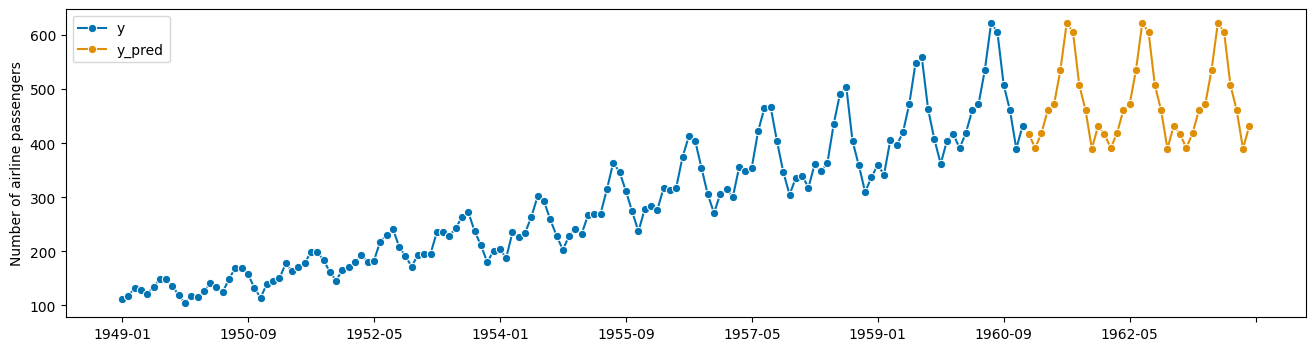

In [5]:
# AIRLINE TEST
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sklearn.metrics import mean_absolute_error
from sktime.utils.plotting import plot_series

# step 1: data specification
y = load_airline()

# step 2: specifying forecasting horizon
fh = np.arange(1, 37)

# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last", sp=12)

# step 4: fitting the forecaster
forecaster.fit(y)

# step 5: querying predictions
y_pred = forecaster.predict(fh)

# optional: plotting predictions and past data
plot_series(y, y_pred, labels=["y", "y_pred"])

108 36


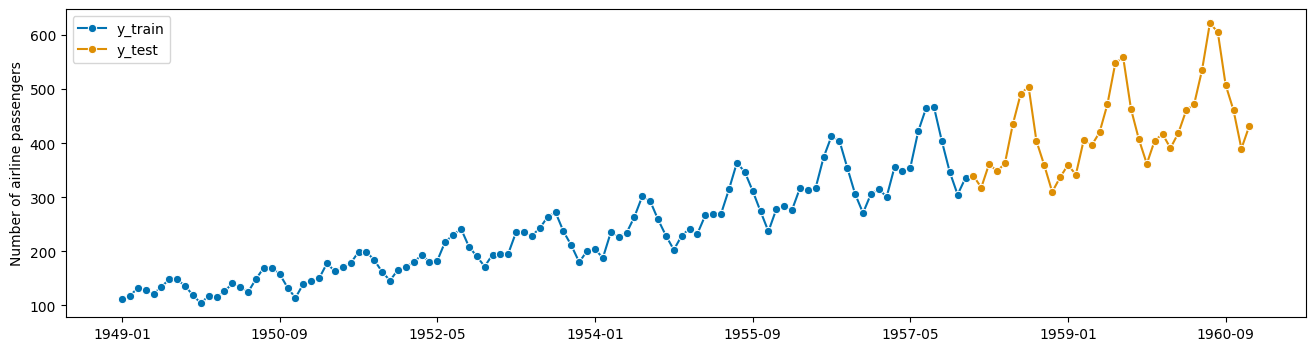

In [6]:
# airline test 2
from sktime.datasets import load_airline
from sktime.split import temporal_train_test_split

y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
# we will try to forecast y_test from y_train

# plotting for illustration
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

In [7]:
# we can simply take the indices from `y_test` where they already are stored
fh = ForecastingHorizon(y_test.index, is_relative=False)

forecaster = NaiveForecaster(strategy="last", sp=12)

forecaster.fit(y_train)

# y_pred will contain the predictions
y_pred = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

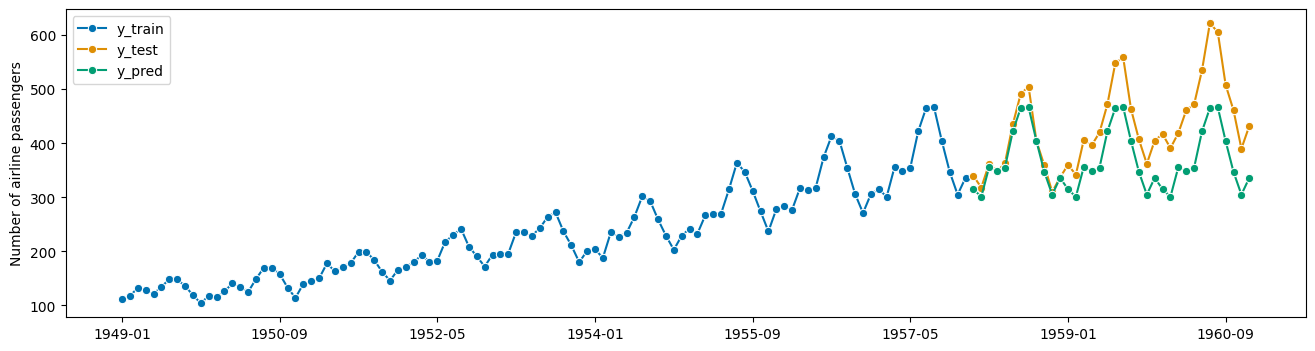

In [8]:
# plotting for illustration
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [9]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
# option 1: using the lean function interface
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)
# note: the FIRST argument is the ground truth, the SECOND argument are the forecasts
#       the order matters for most metrics in general

0.13189432350948402

### AutoARIMA 

In [10]:
# AutoARIMA AIRLINE TEST test
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.model_evaluation import evaluate
from sktime.split import ExpandingWindowSplitter

forecaster = AutoARIMA(sp=12, suppress_warnings=True)

cv = ExpandingWindowSplitter(
    step_length=12, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], initial_window=72
)

df = evaluate(forecaster=forecaster, y=y, cv=cv, strategy="refit", return_data=True)

df.iloc[:, :5]

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,0.061710,10.613045,0.014691,72,1954-12,Period 1949-01 112.0 1949-02 118.0 1949-...,Period 1955-01 242.0 1955-02 233.0 1955-...,1955-01 232.146574 1955-02 222.992091 19...
1,0.050042,4.956998,0.015470,84,1955-12,Period 1949-01 112.0 1949-02 118.0 1949-...,Period 1956-01 284.0 1956-02 277.0 1956-...,1956-01 282.568762 1956-02 269.056668 19...
2,0.029802,7.483344,0.004497,96,1956-12,Period 1949-01 112.0 1949-02 118.0 1949-...,Period 1957-01 315.0 1957-02 301.0 1957-...,1957-01 314.174145 1957-02 306.588343 19...
3,0.053773,2.975761,0.002841,108,1957-12,Period 1949-01 112.0 1949-02 118.0 1949-...,Period 1958-01 340.0 1958-02 318.0 1958-...,1958-01 345.964471 1958-02 331.731920 19...
4,0.073820,9.193494,0.006562,120,1958-12,Period 1949-01 112.0 1949-02 118.0 1949-...,Period 1959-01 360.0 1959-02 342.0 1959-...,1959-01 345.739350 1959-02 326.334142 19...
5,0.030976,9.816109,0.005783,132,1959-12,Period 1949-01 112.0 1949-02 118.0 1949-...,Period 1960-01 417.0 1960-02 391.0 1960-...,1960-01 419.967172 1960-02 399.849851 19...


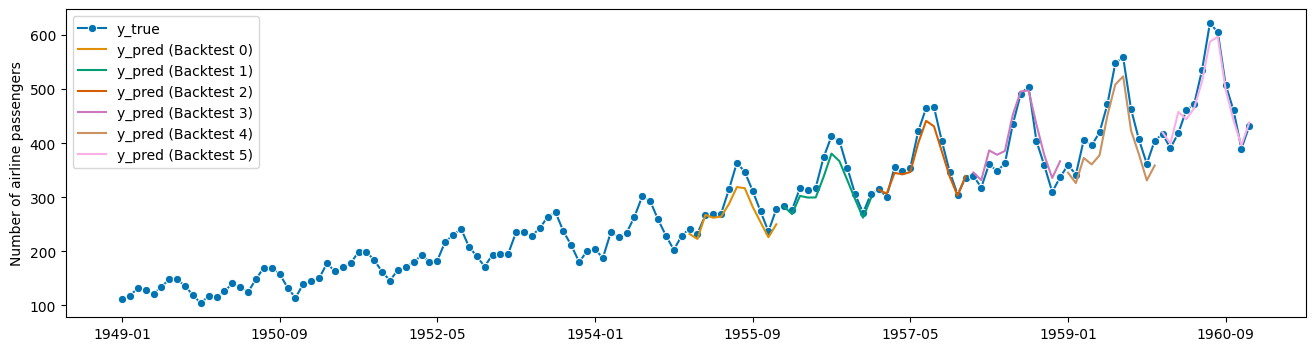

In [11]:
# visualization of a forecaster evaluation
fig, ax = plot_series(
    y,
    df["y_pred"].iloc[0],
    df["y_pred"].iloc[1],
    df["y_pred"].iloc[2],
    df["y_pred"].iloc[3],
    df["y_pred"].iloc[4],
    df["y_pred"].iloc[5],
    markers=["o", "", "", "", "", "", ""],
    labels=["y_true"] + ["y_pred (Backtest " + str(x) + ")" for x in range(6)],
)
ax.legend();

### KNeigbors -- make_reduction

0.12887507224382988

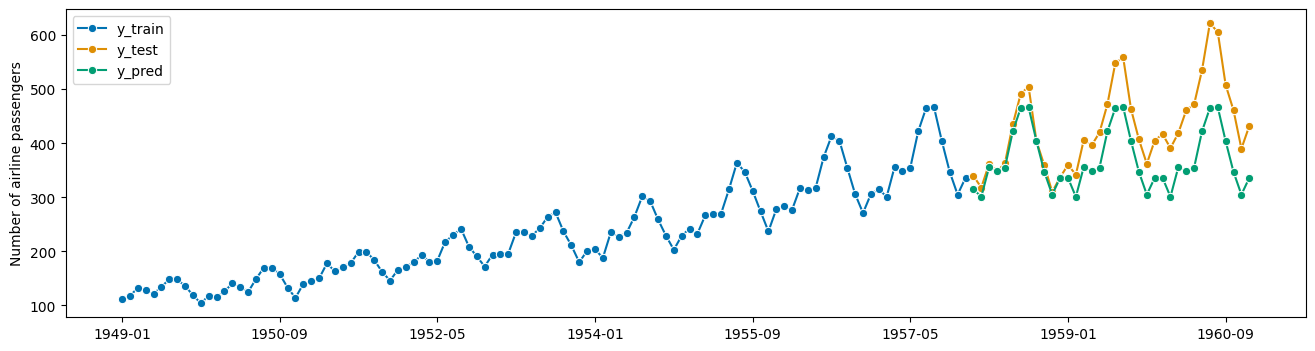

In [12]:
## kneighbors
# imports necessary for this chapter
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.split import temporal_train_test_split
from sktime.utils.plotting import plot_series

# data loading for illustration (see section 1 for explanation)
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
fh = ForecastingHorizon(y_test.index, is_relative=False)

from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction

regressor = KNeighborsRegressor(n_neighbors=1) #regressor params for tuning
forecaster = make_reduction(regressor, window_length=15, strategy="recursive") #window length params for tuning

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)


In [13]:
forecaster.get_params()

{'estimator': KNeighborsRegressor(n_neighbors=1),
 'pooling': 'local',
 'transformers': None,
 'window_length': 15,
 'estimator__algorithm': 'auto',
 'estimator__leaf_size': 30,
 'estimator__metric': 'minkowski',
 'estimator__metric_params': None,
 'estimator__n_jobs': None,
 'estimator__n_neighbors': 1,
 'estimator__p': 2,
 'estimator__weights': 'uniform'}

A common composition motif is pipelining: for example, first deseasonalizing or detrending the data, then forecasting the detrended/deseasonalized series. When forecasting, one needs to add the trend and seasonal component back to the data.

### forecasting pipeline

In [18]:
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer

/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/project_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


0.13969973379847642

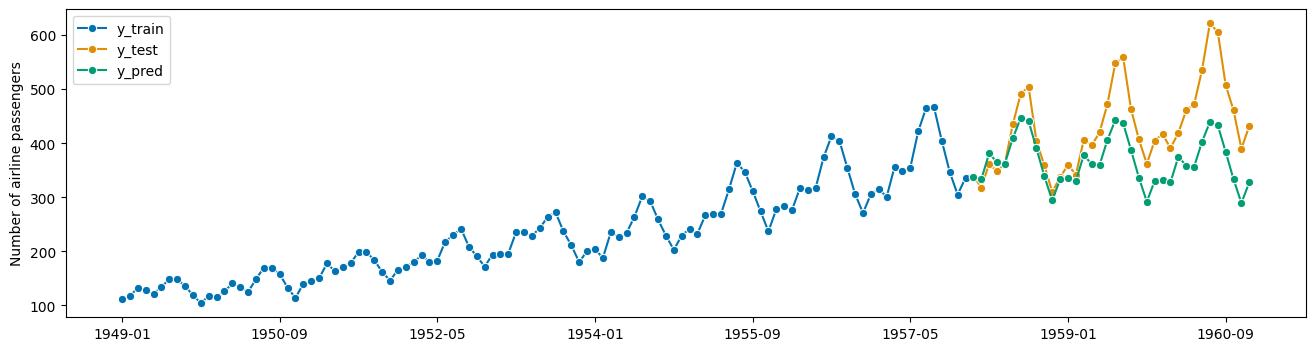

In [19]:
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("forecast", ARIMA()),
    ]
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [20]:
forecaster = Deseasonalizer(model="multiplicative", sp=12) * ARIMA()
forecaster

TransformedTargetForecaster(steps=[Deseasonalizer(model='multiplicative',
                                                  sp=12),
                                   ARIMA()])

In [21]:
forecaster = (
    Deseasonalizer(model="multiplicative", sp=12)
    * Deseasonalizer(model="multiplicative", sp=3)
    * ARIMA()
)

forecaster.get_params()

{'steps': [Deseasonalizer(model='multiplicative', sp=12),
  Deseasonalizer(model='multiplicative', sp=3),
  ARIMA()],
 'Deseasonalizer_1': Deseasonalizer(model='multiplicative', sp=12),
 'Deseasonalizer_2': Deseasonalizer(model='multiplicative', sp=3),
 'ARIMA': ARIMA(),
 'Deseasonalizer_1__model': 'multiplicative',
 'Deseasonalizer_1__sp': 12,
 'Deseasonalizer_2__model': 'multiplicative',
 'Deseasonalizer_2__sp': 3,
 'ARIMA__concentrate_scale': False,
 'ARIMA__enforce_invertibility': True,
 'ARIMA__enforce_stationarity': True,
 'ARIMA__hamilton_representation': False,
 'ARIMA__maxiter': 50,
 'ARIMA__measurement_error': False,
 'ARIMA__method': 'lbfgs',
 'ARIMA__mle_regression': True,
 'ARIMA__order': (1, 0, 0),
 'ARIMA__out_of_sample_size': 0,
 'ARIMA__scoring': 'mse',
 'ARIMA__scoring_args': None,
 'ARIMA__seasonal_order': (0, 0, 0, 0),
 'ARIMA__simple_differencing': False,
 'ARIMA__start_params': None,
 'ARIMA__suppress_warnings': False,
 'ARIMA__time_varying_regression': False,
 'A

In [22]:
from sktime.transformations.series.func_transform import FunctionTransformer

forecaster = ARIMA() * FunctionTransformer(lambda y: y.round())
forecaster.fit_predict(y, fh=fh).head(3)

Period
1958-01    334.0
1958-02    338.0
1958-03    317.0
Freq: M, Name: Number of airline passengers, dtype: float64

In [23]:
forecaster = (
    Deseasonalizer(model="multiplicative", sp=12)
    * Deseasonalizer(model="multiplicative", sp=3)
    * ARIMA()
    * FunctionTransformer(lambda y: y.round())
)

forecaster.fit_predict(y_train, fh=fh).head(3)

/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/project_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Period
1958-01    339.0
1958-02    334.0
1958-03    381.0
Freq: M, Name: Number of airline passengers, dtype: float64